In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time
# For progress visualization
from tqdm.notebook import tqdm
# For mixed-precision training
from apex import amp

from matplotlib.image import imread
from pathlib import Path
import glob
from PIL import Image

from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader

from IPython.display import Image, display

In [5]:
use_gpu = torch.cuda.is_available()

# Download and unzip data

In [7]:
# Download and unzip (use validation set first)
!wget http://data.csail.mit.edu/places/places365/val_256.tar

--2020-06-12 19:06:31--  http://data.csail.mit.edu/places/places365/val_256.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158400 (501M) [application/octet-stream]
Saving to: ‘val_256.tar’

val_256.tar         100%[===================>] 500.83M  9.19MB/s    in 38s     

2020-06-12 19:07:10 (13.2 MB/s) - ‘val_256.tar’ saved [525158400/525158400]



In [ ]:
# !tar -xvf val_256.tar

In [9]:
# import os
# os.makedirs('images/train/class/', exist_ok=True) # 29,200 images
# os.makedirs('images/val/class/', exist_ok=True)   #  7,300 images
# for i, file in enumerate(os.listdir('val_256')):
#     if i < 7300: # first 7300 will be val
#         os.rename('val_256/' + file, 'images/val/class/' + file)
#     else: # others will be train
#         os.rename('val_256/' + file, 'images/train/class/' + file)

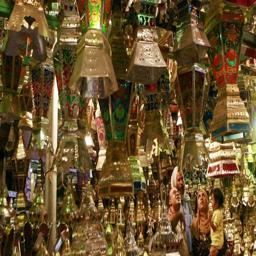

In [10]:
display(Image(filename='images/train/class/Places365_val_00030281.jpg'))

# Dataset

In [14]:
class ImageDataset(Dataset):
    def __init__(self, files):
        self.files = np.array(files)
        self.length = len(files)
    
    def __getitem__(self, idx):
        img = imread(self.files[idx])
        if img.shape == (256, 256, 3):  # if a color image
            img_lab = rgb2lab(img)
            img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]  # normalize L, a, b dimensions
            img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
            img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
        else:  # if a grayscale image
            img_lightness = (img/255)[None, :, :]
            img_ab = np.zeros(shape=(2, 256, 256))
        return img_lightness, img_ab
    
    def __len__(self):
        return self.length

In [15]:
train_files = glob.glob("images/train/class/*.jpg")
len(train_files)

29200

In [16]:
val_files = glob.glob("images/val/class/*.jpg")
len(val_files)

7300

In [17]:
train_ds = ImageDataset(train_files)
val_ds = ImageDataset(val_files)

In [18]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=10)

In [19]:
len(train_dl)

913

In [20]:
in_, out_ = next(iter(train_dl))

In [21]:
in_.shape

torch.Size([32, 1, 256, 256])

In [22]:
out_.shape

torch.Size([32, 2, 256, 256])

# Model

In [23]:
def basic_block(in_, out_, kernel_size=3, stride=1):
    """Return a block consisting of a conv2d, ReLU and BatchNorm2d layer."""
    padding = kernel_size // 2
    block = nn.Sequential(
        nn.Conv2d(in_, out_, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_))
    return block

In [24]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.layers = nn.Sequential(
            basic_block(1, 64, kernel_size=3, stride=2),
            basic_block(64, 128, kernel_size=3, stride=2),
            basic_block(128, 256, kernel_size=3, stride=2),
            basic_block(256, 512, kernel_size=3, stride=1),
            basic_block(512, 256, kernel_size=3, stride=1))
        self.upsample = nn.Upsample(scale_factor=8)
        self.out_layer = basic_block(256, 2, kernel_size=3, stride=1)
    
    def forward(self, x):
        x = self.layers(x)
        x = self.upsample(x)
        return self.out_layer(x)

In [25]:
criterion = nn.MSELoss().cuda()

In [26]:
def train_epoch(model, train_dl, val_dl, optimizer, epochs=10):
    iterations = len(train_dl) * epochs
    pbar = tqdm(total=iterations)
    best_val_loss = float("inf")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl:
            x = x.float().cuda()
            y = y.float().cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.shape[0]
            total += y.shape[0]
            pbar.update()
        val_loss = val_metrics(model, val_dl)
        print(f"train loss: {total_loss/total:.8f}\tval loss: {val_loss:.8f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            path = f"models/model_{best_val_loss:.6f}"
            save_model(model, path)
            print(path)
    
    return best_val_loss

In [27]:
def val_metrics(model, val_dl):
    model.eval()
    total_loss = 0
    total = 0
    y_pred = []
    y_true = []
    
    for x, y in val_dl:
        x = x.float().cuda()
        y = y.float()
        out = model(x)
        loss = criterion(out, y.cuda())
        total_loss += loss.item() * y.shape[0]
        total += y.shape[0]
        y_pred.append(out.cpu().detach().numpy())
        y_true.append(y)
    
    y_pred = np.vstack(y_pred)
    y_true = np.vstack(y_true)
    return total_loss/total

In [28]:
def save_model(model, path): torch.save(model.state_dict(), path)

def load_model(model, path): model.load_state_dict(torch.load(path))

In [29]:
model = ColorizationNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [30]:
model, optimizer = amp.initialize(model, optimizer)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [34]:
best_val = train_epoch(model, train_dl, val_dl, optimizer, epochs=5)

train loss: 0.00336122	val loss: 0.00318938
models/model_0.003189
train loss: 0.00332573	val loss: 0.00315197
models/model_0.003152
train loss: 0.00330433	val loss: 0.00330413
train loss: 0.00328132	val loss: 0.00321306
train loss: 0.00326281	val loss: 0.00319201


In [43]:
best_val = train_epoch(model, train_dl, val_dl, optimizer, epochs=5)

train loss: 0.00328437	val loss: 0.00316369
models/model_0.003164
train loss: 0.00323554	val loss: 0.00356033
train loss: 0.00324337	val loss: 0.00316663
train loss: 0.00321968	val loss: inf
train loss: 0.00320161	val loss: 0.00330493


# Check results

In [44]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [45]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()

  # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab) in enumerate(val_loader):
        data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
        already_saved_images = True
    for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
        print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

    print('Finished validation.')
    return losses.avg

In [46]:
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

In [49]:
model_val = ColorizationNet().cuda()
load_model(model_val, f"models/model_{best_val:.6f}")

In [50]:
save_images = True
with torch.no_grad():
    validate(val_dl, model_val, criterion, save_images, 0)

Finished validation.


<Figure size 432x288 with 0 Axes>

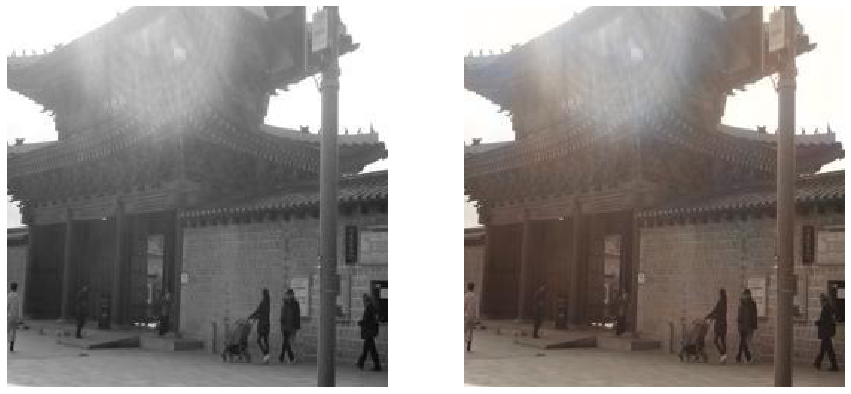

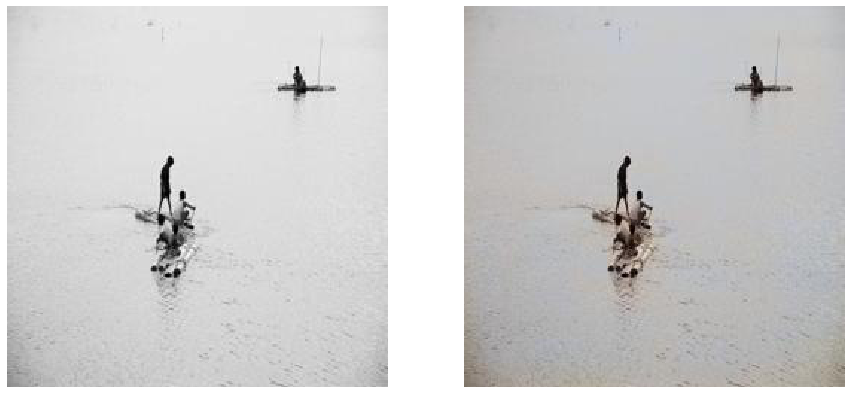

In [51]:
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-7296-epoch-0.jpg', 'outputs/gray/img-7296-epoch-0.jpg'),
               ('outputs/color/img-7297-epoch-0.jpg', 'outputs/gray/img-7297-epoch-0.jpg')]
for c, g in image_pairs:
    color = mpimg.imread(c)
    gray  = mpimg.imread(g)
    f, axarr = plt.subplots(1, 2)
    f.set_size_inches(15, 15)
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(color)
    axarr[0].axis('off'), axarr[1].axis('off')
    plt.show()